# Demo: *Μοντέλο Ευθυγράμμισης Ομιλίας–Κειμένου*

In [20]:
import os, json
import librosa
import torch
import matplotlib.pyplot as plt
from evaluate import load_model_from_checkpoint
from preprocess import embed_speech, embed_transcripts
from math import floor
from transformers import AutoModel, AutoProcessor
from sentence_transformers import SentenceTransformer

In [ ]:
# Interactive audio chooser: upload or provide local path
import io, tempfile
import ipywidgets as widgets
from IPython.display import display

file_uploader = widgets.FileUpload(accept='.wav,.mp3', multiple=False)
file_path_text = widgets.Text(value='', description='Path:')
load_button = widgets.Button(description='Load audio')
out = widgets.Output()
display(widgets.HBox([file_uploader, file_path_text, load_button]), out)

def _get_uploaded_file(upl):
    if not upl:
        return None
    val = list(upl.value.values())[0] if hasattr(upl, 'value') and upl.value else None
    if val is None:
        return None
    data = None
    name = None
    if isinstance(val, dict):
        data = val.get('content') or val.get('data')
        name = (val.get('metadata') or {}).get('name') or val.get('name')
    else:
        try:
            name = val[0]; data = val[1]
        except Exception:
            return None
    return (name, data)

def load_audio(b):
    with out:
        out.clear_output()
        fp = None
        uploaded = _get_uploaded_file(file_uploader)
        if uploaded is not None:
            name, data = uploaded
            if data is None:
                print('No data found in uploaded file')
                return
            suffix = '_' + (name or 'audio')
            tmp = tempfile.NamedTemporaryFile(delete=False, suffix=suffix)
            tmp.write(data)
            tmp.flush(); tmp.close()
            fp = tmp.name
        elif file_path_text.value:
            fp = file_path_text.value
        else:
            print('Provide a file via upload or enter a local path in the Path field.')
            return
        try:
            waveform_local, sr_local = librosa.load(fp, sr=16000)
            globals()['waveform'] = waveform_local
            globals()['sr'] = sr_local
            plt.figure(figsize=(10,2))
            plt.plot(waveform_local)
            plt.title(fp)
            plt.show()
            print(f'Loaded: {fp} (sr={sr_local}, samples={len(waveform_local)})')
        except Exception as e:
            print('Error loading audio:', e)

load_button.on_click(load_audio)

ModuleNotFoundError: No module named 'ipywidgets'

In [2]:
with open("configs/cnn-aligner.json", "r") as f:
    config = json.load(f)
config

{'speech_dim': 384,
 'text_dim': 384,
 'hidden_dim': 256,
 'kernel_sizes': [3, 5, 7],
 'num_layers': 2,
 'pool_stride': 2,
 'dropout': 0.1,
 'init_tau': 0.07}

In [3]:
model = load_model_from_checkpoint("/mnt/h/output/checkpoints/cnn_alignment_model.ckpt",
                                   config).to("cuda")
print(model)

AlignmentModel(
  (adapter): CnnAdapter(
    (convs): ModuleList(
      (0): ModuleList(
        (0): Conv1d(384, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(384, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (2): Conv1d(384, 256, kernel_size=(7,), stride=(1,), padding=(3,))
      )
      (1): ModuleList(
        (0): Conv1d(768, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(768, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (2): Conv1d(768, 256, kernel_size=(7,), stride=(1,), padding=(3,))
      )
    )
    (norms): ModuleList(
      (0-1): 2 x LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (proj): Conv1d(768, 384, kernel_size=(1,), stride=(1,))
    (dropout): Dropout(p=0.1, inplace=False)
    (act): GELU(approximate='none')
  )
)


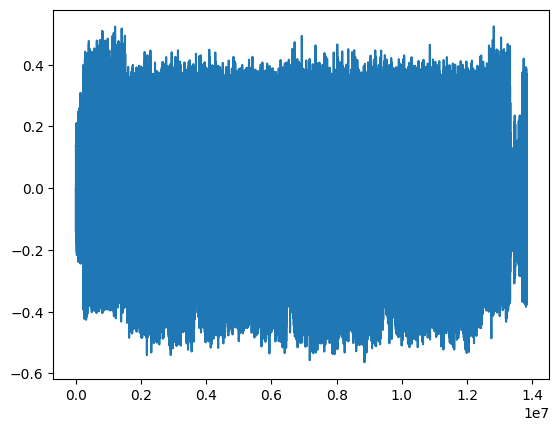

In [ ]:
# This cell now uses the waveform loaded by the widget above.
if 'waveform' in globals():
    plt.figure(figsize=(10,2))
    plt.plot(waveform)
    plt.title('Loaded audio waveform')
    plt.show()
else:
    print('No waveform loaded yet. Use the upload/path widget above to load audio.')

In [5]:
segment_duration = 10 * 16_000
stride = 5 * 16_000

In [6]:
def get_segment(waveform, k):
    start = k * stride
    end = start + segment_duration
    return waveform[start:end]

def segment_audio(waveform):
    segments = []
    for k in range(floor((len(waveform) - segment_duration) / stride) + 1):
        segments.append(get_segment(waveform, k))
    return segments

In [23]:
segments = segment_audio(waveform)

In [8]:
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")
whisper_model = AutoModel.from_pretrained("openai/whisper-tiny").to("cuda")
te_model = SentenceTransformer("intfloat/multilingual-e5-small", device="cuda")

In [9]:
speech_embeds, attn_masks, = embed_speech(preprocessor=processor,
                                          model=whisper_model,
                                          speech=segment_audio(waveform),
                                          sr=16000,
                                          device="cuda")
speech_embeds.shape, attn_masks.shape

(torch.Size([171, 1500, 384]), torch.Size([171, 1500]))

In [1]:
query = "Ολόμελεια"
text_embed = embed_transcripts(encoder=te_model, batch={'sentence': [query]})
text_embed.shape

NameError: name 'embed_transcripts' is not defined

In [ ]:
final_embeds = model.encode(speech_hidden=speech_embeds.to("cuda"),
                            speech_mask=attn_masks.to("cuda"))
final_embeds.shape

torch.Size([171, 384])

In [44]:
similratires = (final_embeds.detach() @ text_embed.detach().T)
similratires.shape

torch.Size([171, 1])

In [45]:
topk = torch.topk(similratires, k=5, dim=0)
matched_segments = [segments[i] for i in topk.indices.squeeze().tolist()]

In [46]:
matched_segments, topk.values.squeeze().tolist()

([array([ 0.1031672 , -0.16003393,  0.05299948, ...,  0.12797555,
          0.1641275 ,  0.16180894], shape=(160000,), dtype=float32),
  array([0.01849189, 0.01606681, 0.00970873, ..., 0.22384156, 0.21929935,
         0.20884442], shape=(160000,), dtype=float32),
  array([ 0.14602624,  0.15160975,  0.14758566, ..., -0.00925968,
         -0.00548294, -0.01904397], shape=(160000,), dtype=float32),
  array([ 0.1255048 ,  0.13746044,  0.14104243, ..., -0.01470387,
         -0.01349496, -0.01314586], shape=(160000,), dtype=float32),
  array([-0.04086276, -0.05519196, -0.06105744, ...,  0.03127167,
          0.02776227,  0.01533772], shape=(160000,), dtype=float32)],
 [0.16444602608680725,
  0.10804663598537445,
  0.07851563394069672,
  0.07764590531587601,
  0.07672388851642609])

In [47]:
import IPython.display as ipd

# Play the first 5 matched segments

for i, seg in enumerate(matched_segments[:5]):
    print(f"Playing segment {i+1}")
    ipd.display(ipd.Audio(seg, rate=sr))

Playing segment 1


Playing segment 2


Playing segment 3


Playing segment 4


Playing segment 5
